<a href="https://colab.research.google.com/github/Raoina/Calculator/blob/main/notebooks/01_Cutting_Reshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/LUCAS.SOIL_corr.csv'


In [7]:
import pandas as pd

df = pd.read_csv(file_path)

df.head()

/tmp/ipython-input-3672932280.py:3: DtypeWarning: Columns (1,2,4216,4231,4234,4237,4274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Unnamed: 0,sample.ID,ID,date,spc.400,spc.400.5,spc.401,spc.401.5,spc.402,spc.402.5,...,WRBLV1,WRBADJ1,PARMADO1,PARMADO2,PARMADO3,PARMASE1,PARMASE2,PARMASE3,MIN_TOP,mineral
0,4,100,100,2011-01-24 16:02:25,0.831705,0.839111,0.846473,0.853773,0.860988,0.868098,...,CM,dy,3.0,31.0,310.0,5.0,56.0,561.0,KQ,mineral
1,5,1000,1000,2010-09-30 14:50:01,0.706027,0.714901,0.723727,0.732480,0.741142,0.749684,...,CM,dy,3.0,31.0,311.0,3.0,31.0,310.0,KQ,mineral
2,6,10000,10000,2010-10-19 12:06:16,0.666238,0.676472,0.686654,0.696757,0.706753,0.716615,...,CM,ca,2.0,21.0,214.0,0.0,0.0,0.0,MS,mineral
3,7,10001,10001,2010-10-19 15:00:01,0.698136,0.706548,0.714909,0.723197,0.731384,0.739448,...,CM,dy,3.0,31.0,310.0,4.0,42.0,420.0,KQ,mineral
4,8,10002,10002,2011-04-30 12:26:27,0.675433,0.684820,0.694163,0.703438,0.712620,0.721693,...,LV,ha,7.0,71.0,710.0,6.0,62.0,620.0,M,mineral


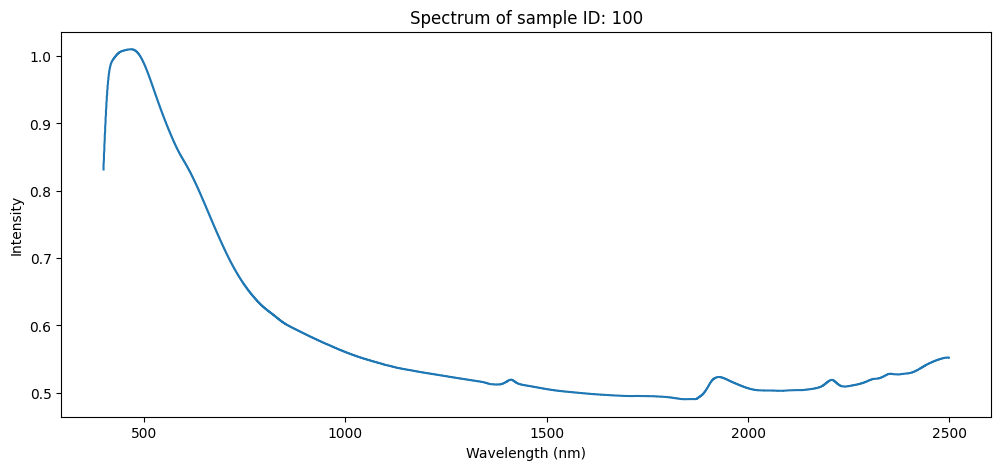

In [9]:
import matplotlib.pyplot as plt

row = df.iloc[0]

spectrum = row.filter(like="spc.")

wavelengths = [float(col.split(".")[1]) for col in spectrum.index]
intensity = spectrum.values


plt.figure(figsize=(12, 5))
plt.plot(wavelengths, intensity)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Spectrum of sample ID: {}".format(row['sample.ID']))
plt.show()


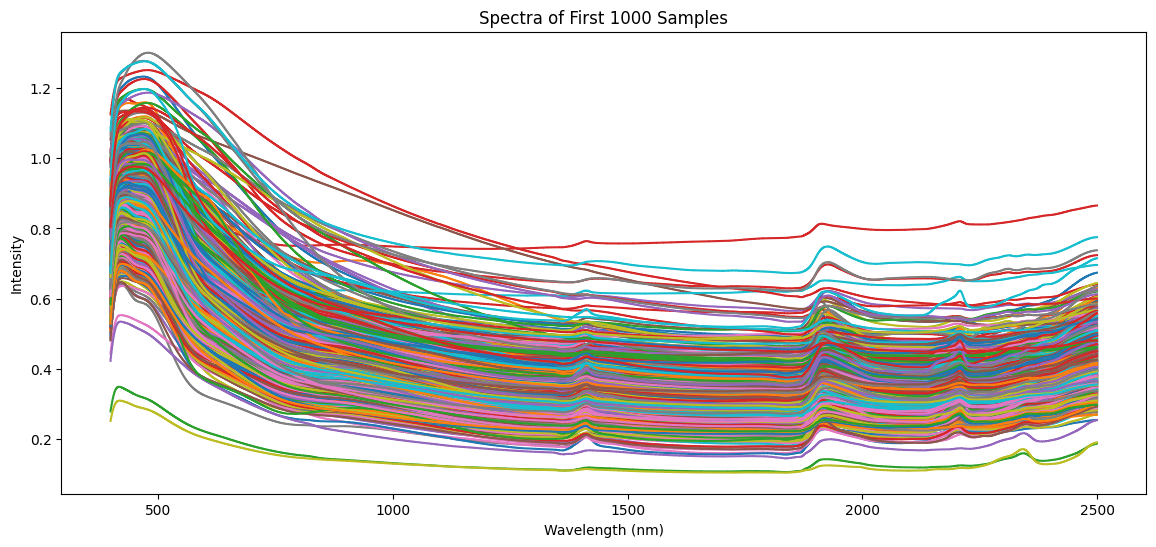

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

num_samples = 1000

for i in range(num_samples):
    row = df.iloc[i]
    spectrum = row.filter(like="spc.")
    wavelengths = [float(col.split(".")[1]) for col in spectrum.index]
    intensity = spectrum.values
    plt.plot(wavelengths, intensity)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title(f"Spectra of First {num_samples} Samples")
plt.show()


In [21]:
import pandas as pd
import numpy as np
from scipy.stats import skew

columns = {
    "OC": "OC (g⋅kg⁻¹)",
    "N": "N (g⋅kg⁻¹)",
    "CEC": "CEC (cmol+⋅kg⁻¹)",
    "pH.in.H2O": "pH",
    "sand": "Sand (%)",
    "clay": "Clay (%)"
}

rows = []

for col, name in columns.items():
    data = df[col].dropna()
    stats = {
        "Property": name,
        "Total": len(data),
        "Min": np.min(data),
        "Q1": np.percentile(data, 25),
        "Median": np.median(data),
        "Q3": np.percentile(data, 75),
        "Max": np.max(data),
        "Mean": np.mean(data),
        "Std": np.std(data, ddof=1),
        "Skew": skew(data, bias=False)
    }
    rows.append(stats)

summary_df = pd.DataFrame(rows)

summary_df = summary_df.round({
    "Min": 2, "Q1": 2, "Median": 2, "Q3": 2,
    "Max": 2, "Mean": 2, "Std": 2, "Skew": 2
})

print(summary_df.to_string(index=False))


        Property  Total  Min    Q1  Median    Q3    Max  Mean   Std  Skew
     OC (g⋅kg⁻¹)  19036 0.00 12.70   20.80 39.70 586.80 50.00 91.31  3.68
      N (g⋅kg⁻¹)  19036 0.00  1.20    1.70  2.90  38.60  2.92  3.76  3.76
CEC (cmol+⋅kg⁻¹)  19036 0.00  7.00   12.40 20.30 234.00 15.76 14.48  4.24
              pH  19036 3.21  5.02    6.21  7.47  10.08  6.20  1.35 -0.08
        Sand (%)  17939 1.00 19.00   42.00 64.00  99.00 42.88 26.11  0.19
        Clay (%)  17939 0.00  8.00   17.00 26.50  79.00 18.88 13.00  0.91


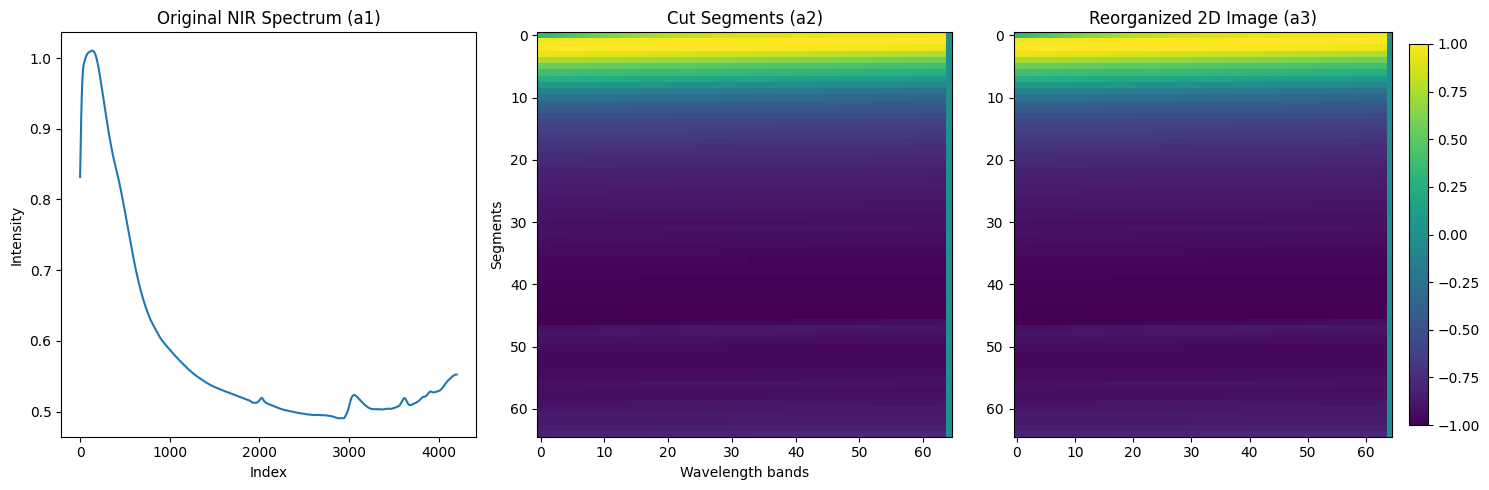

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Select one sample ----------
row = df.iloc[0]
spectrum = row.filter(like="spc.")
intensity = spectrum.values.astype(float)

# ---------- 2. Normalization (-1,1) ----------
min_val, max_val = intensity.min(), intensity.max()
normalized = 2 * (intensity - min_val) / (max_val - min_val) - 1

# ---------- 3. Cutting into 65 bands ----------
total_len = len(normalized)  # should be 4200
bands = 65
window_size = total_len // bands  # ~64
cut_segments = []

for i in range(bands):
    start = i * window_size
    end = start + window_size
    segment = normalized[start:end]

    # pad with zeros if shorter than bands
    if len(segment) < bands:
        segment = np.pad(segment, (0, bands - len(segment)))
    else:
        segment = segment[:bands]

    cut_segments.append(segment)

# ---------- 4. Reshape to 65×65 matrix ----------
img = np.array(cut_segments)

# ---------- 5. Visualization ----------
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# (a1) Original spectrum
axs[0].plot(intensity)
axs[0].set_title("Original NIR Spectrum (a1)")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Intensity")

# (a2) After cutting (bands)
axs[1].imshow(np.array(cut_segments), aspect="auto", cmap="viridis")
axs[1].set_title("Cut Segments (a2)")
axs[1].set_xlabel("Wavelength bands")
axs[1].set_ylabel("Segments")

# (a3) Reorganized 2D image
im = axs[2].imshow(img, cmap="viridis", aspect="auto")
axs[2].set_title("Reorganized 2D Image (a3)")
plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


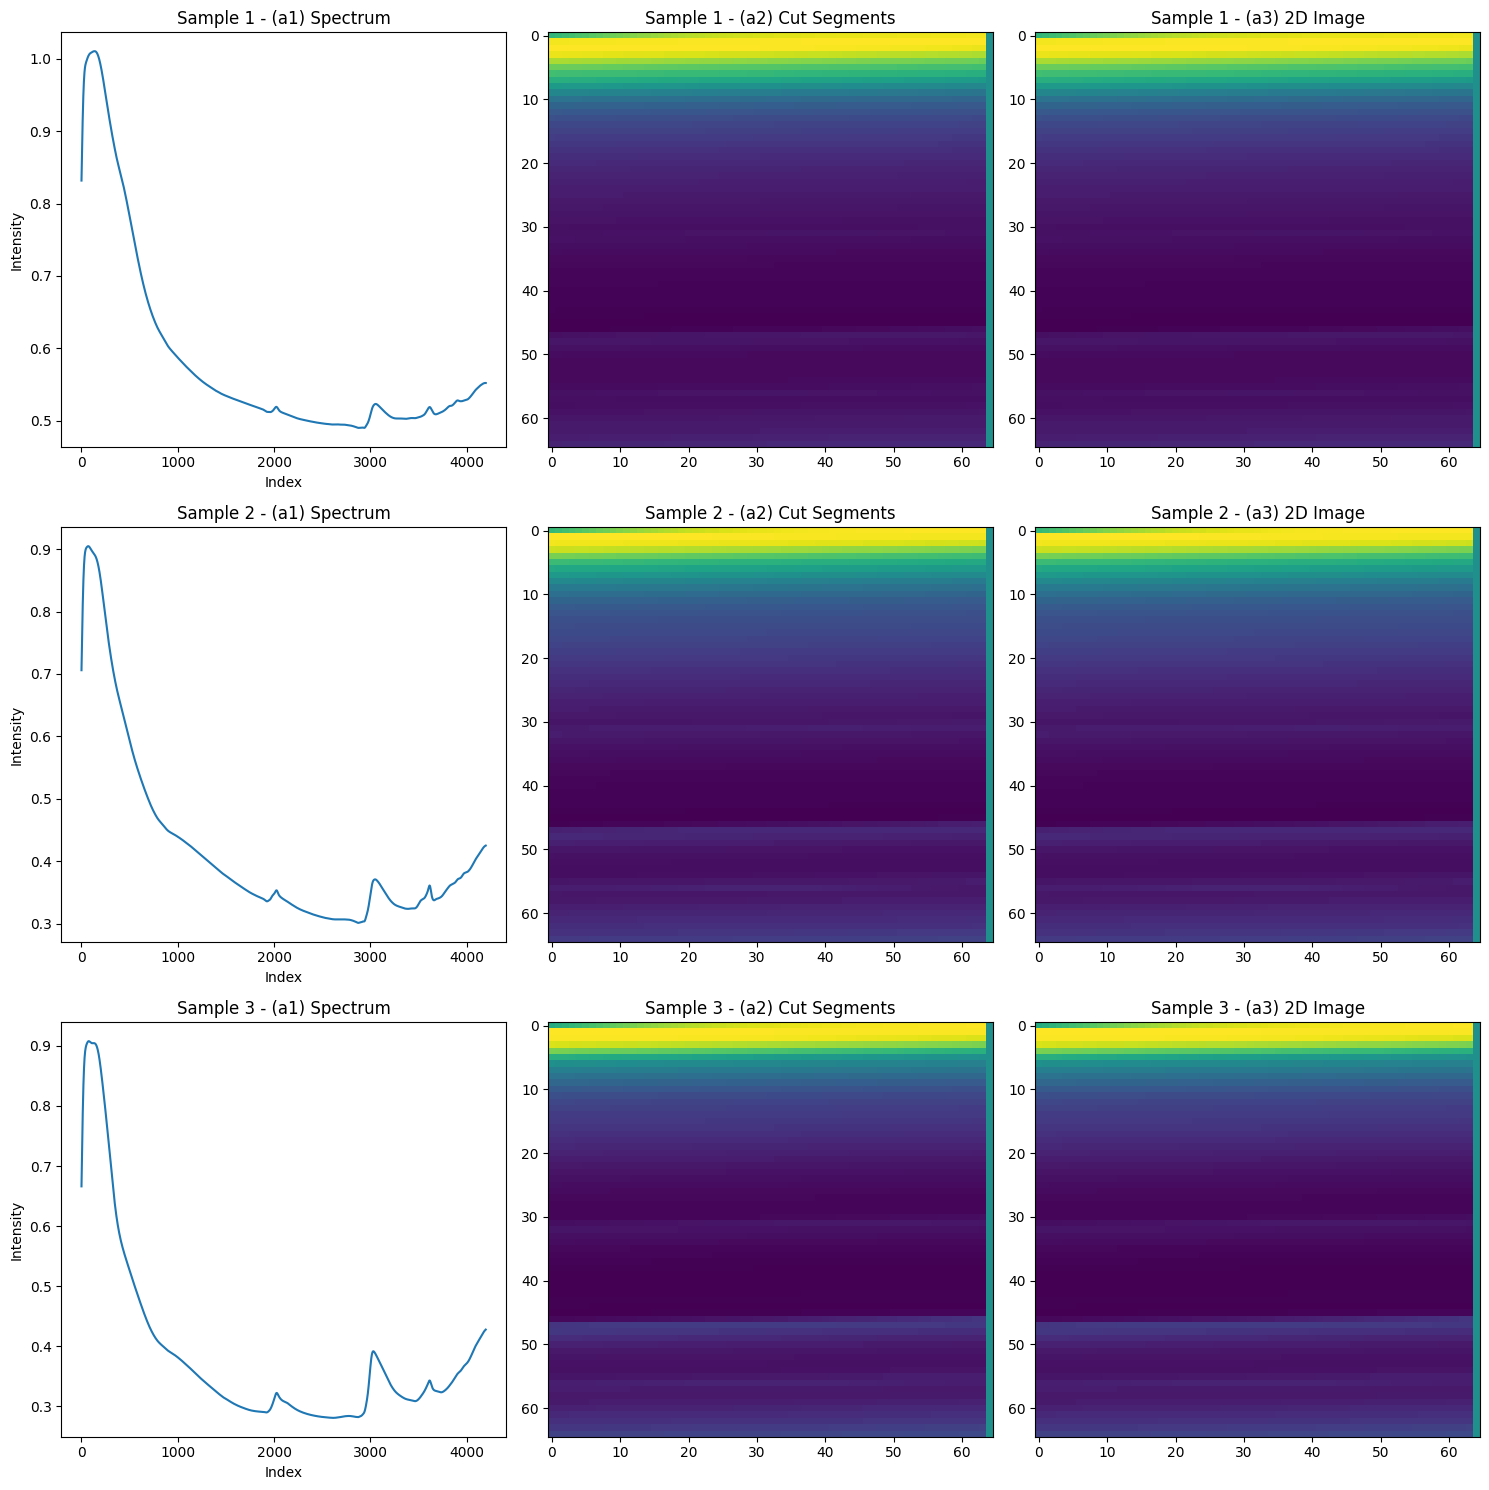

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples to process
num_samples = 3

fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for idx in range(num_samples):
    row = df.iloc[idx]
    spectrum = row.filter(like="spc.")
    intensity = spectrum.values.astype(float)

    # (1) Normalization (-1,1)
    min_val, max_val = intensity.min(), intensity.max()
    normalized = 2 * (intensity - min_val) / (max_val - min_val) - 1

    # (2) Cutting into 65 bands
    total_len = len(normalized)  # usually 4200
    bands = 65
    window_size = total_len // bands
    cut_segments = []

    for i in range(bands):
        start = i * window_size
        end = start + window_size
        segment = normalized[start:end]

        if len(segment) < bands:
            segment = np.pad(segment, (0, bands - len(segment)))
        else:
            segment = segment[:bands]

        cut_segments.append(segment)

    # (3) Reorganized 65×65 matrix
    img = np.array(cut_segments)

    # ---- Plot ----
    # (a1) Original spectrum
    axs[idx, 0].plot(intensity)
    axs[idx, 0].set_title(f"Sample {idx+1} - (a1) Spectrum")
    axs[idx, 0].set_xlabel("Index")
    axs[idx, 0].set_ylabel("Intensity")

    # (a2) Cut Segments
    axs[idx, 1].imshow(np.array(cut_segments), aspect="auto", cmap="viridis")
    axs[idx, 1].set_title(f"Sample {idx+1} - (a2) Cut Segments")

    # (a3) Reorganized 2D Image
    im = axs[idx, 2].imshow(img, cmap="viridis", aspect="auto")
    axs[idx, 2].set_title(f"Sample {idx+1} - (a3) 2D Image")

plt.tight_layout()
plt.show()
